In [68]:
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [69]:
from src.modules import conf, fit, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor, XGBRFRegressor
warnings.simplefilter("ignore")
from datetime import datetime
from feature_engine.creation import MathFeatures
import pickle

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [72]:
race_day = datetime.strptime('2023-11-12-11-30', "%Y-%m-%d-%H-%M")

In [73]:
data = fit.load_pcls(
        'zimola',
        'running',
        conf["Paths"]["pcl"],
        race_day
    )

100%|██████████| 202/202 [00:00<00:00, 481.03it/s] 


In [74]:
low_dist, high_dist = preprocess.segment_data(data)
len(low_dist),len(high_dist)

(51, 120)

In [75]:
test_df = preprocess.load_test_activity(path="tracks/bechovice.gpx",
                                        race_day ='2023-11-12-11-30')
print(len(test_df))

2122


In [76]:
if max(test_df.distance) > 10000:
    train_df = fit.clean_data(pd.concat(high_dist))
else:
    train_df = fit.clean_data(pd.concat(low_dist))
    
train_df = fit.clean_data(pd.concat(high_dist))
len(train_df)

351620

In [77]:
len(train_df.columns),len(test_df.columns)

(132, 61)

In [78]:
len(train_df),len(test_df)

(351620, 2122)

In [79]:
len(train_df[test_df.columns].columns),len(test_df.columns)

(61, 61)

# Cadence

In [84]:
clf = XGBRegressor()

In [85]:
clf.fit(train_df[test_df.columns], train_df.cadence)
test_df['cadence'] = clf.predict(test_df)
test_df['cadence'].mean()

90.44583

In [86]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=15,
          cols=["cadence"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [87]:
clf.fit(train_df[test_df.columns], train_df.heart_rate)
test_df["heart_rate"] = clf.predict(test_df)
test_df["heart_rate"].mean()

159.16379

In [88]:
for fce in ["sum", "mean", "min", "max"]:
    test_df = MathFeatures(variables=["heart_rate", "cadence"], func=fce).fit(test_df).transform(test_df)

In [89]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=12,
          cols=["heart_rate"])
test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [90]:
clf.fit(train_df[test_df.columns], train_df.enhanced_speed)
test_df["enhanced_speed"] = clf.predict(test_df)

In [91]:
test_df.to_csv(f"src/output/zimola_bechovice.csv")

In [92]:
pickle.dump(clf, open("src/models/zimola.sav", 'wb'))

In [93]:
percent_delay = int(len(test_df) * 0.02)  ## 2% delay

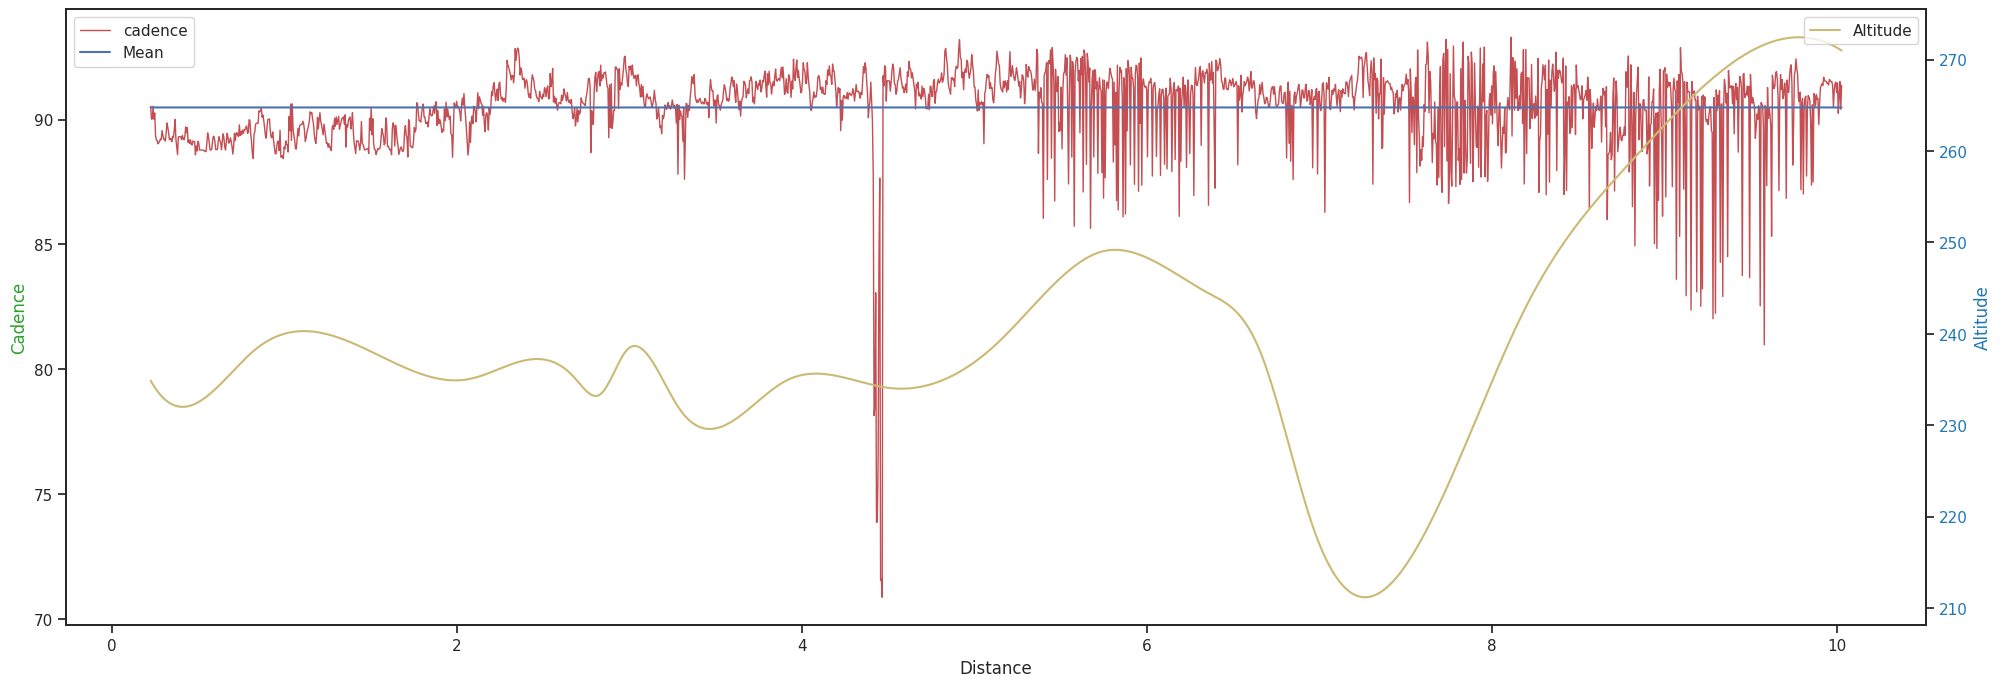

In [94]:
cad_plot = evl.plot(df=test_df[percent_delay:], pred=test_df['cadence'][percent_delay:],endog = "cadence", ylabel="Cadence", color="green")

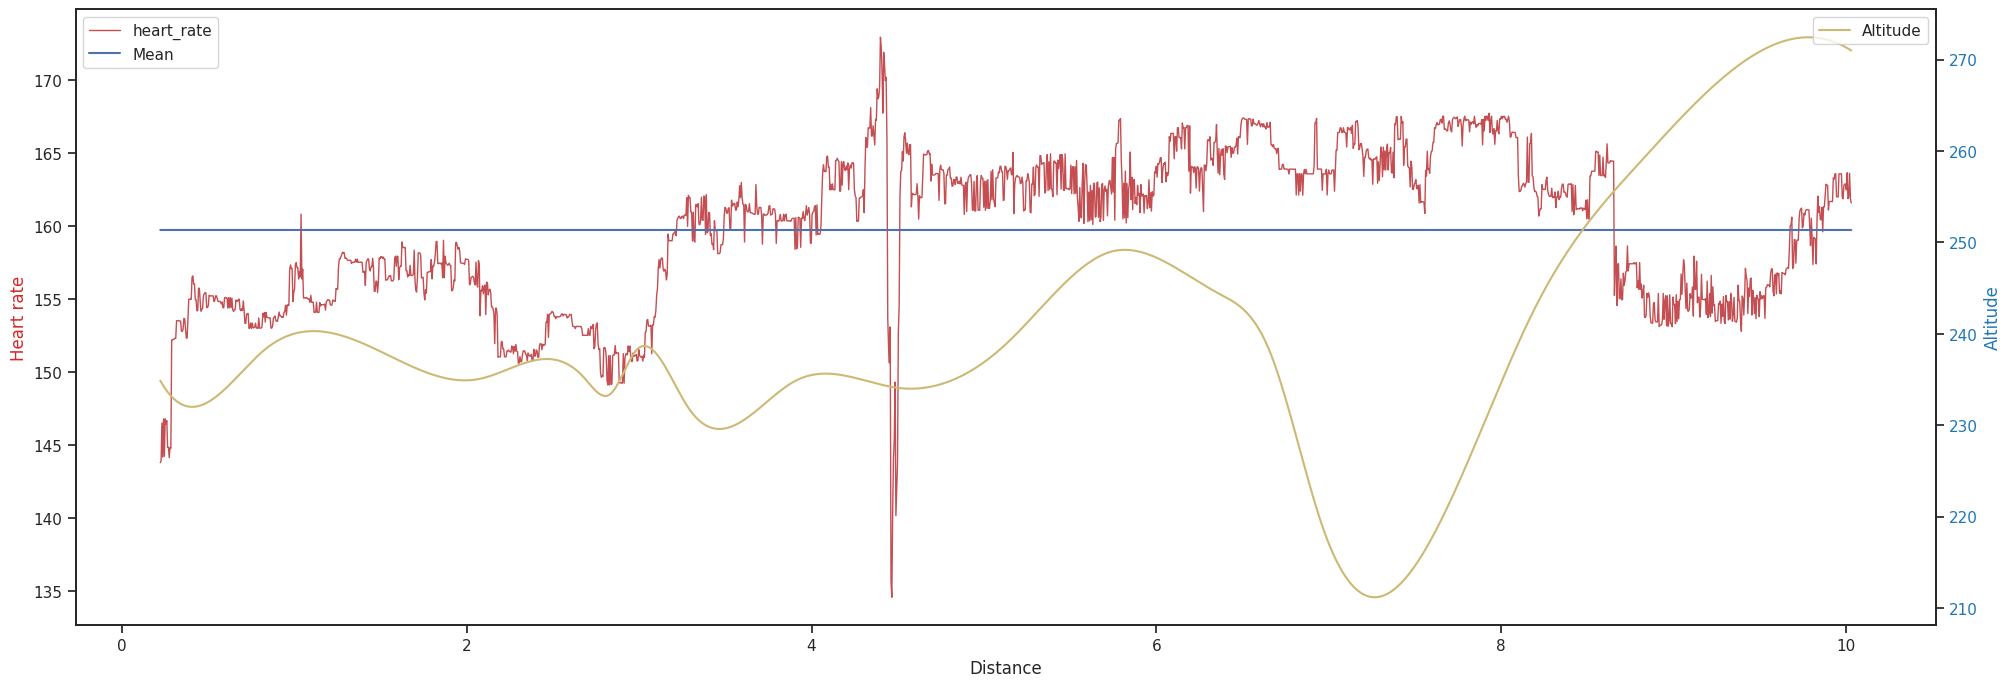

In [95]:
hr_plot = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate",ylabel="Heart rate", color="red")

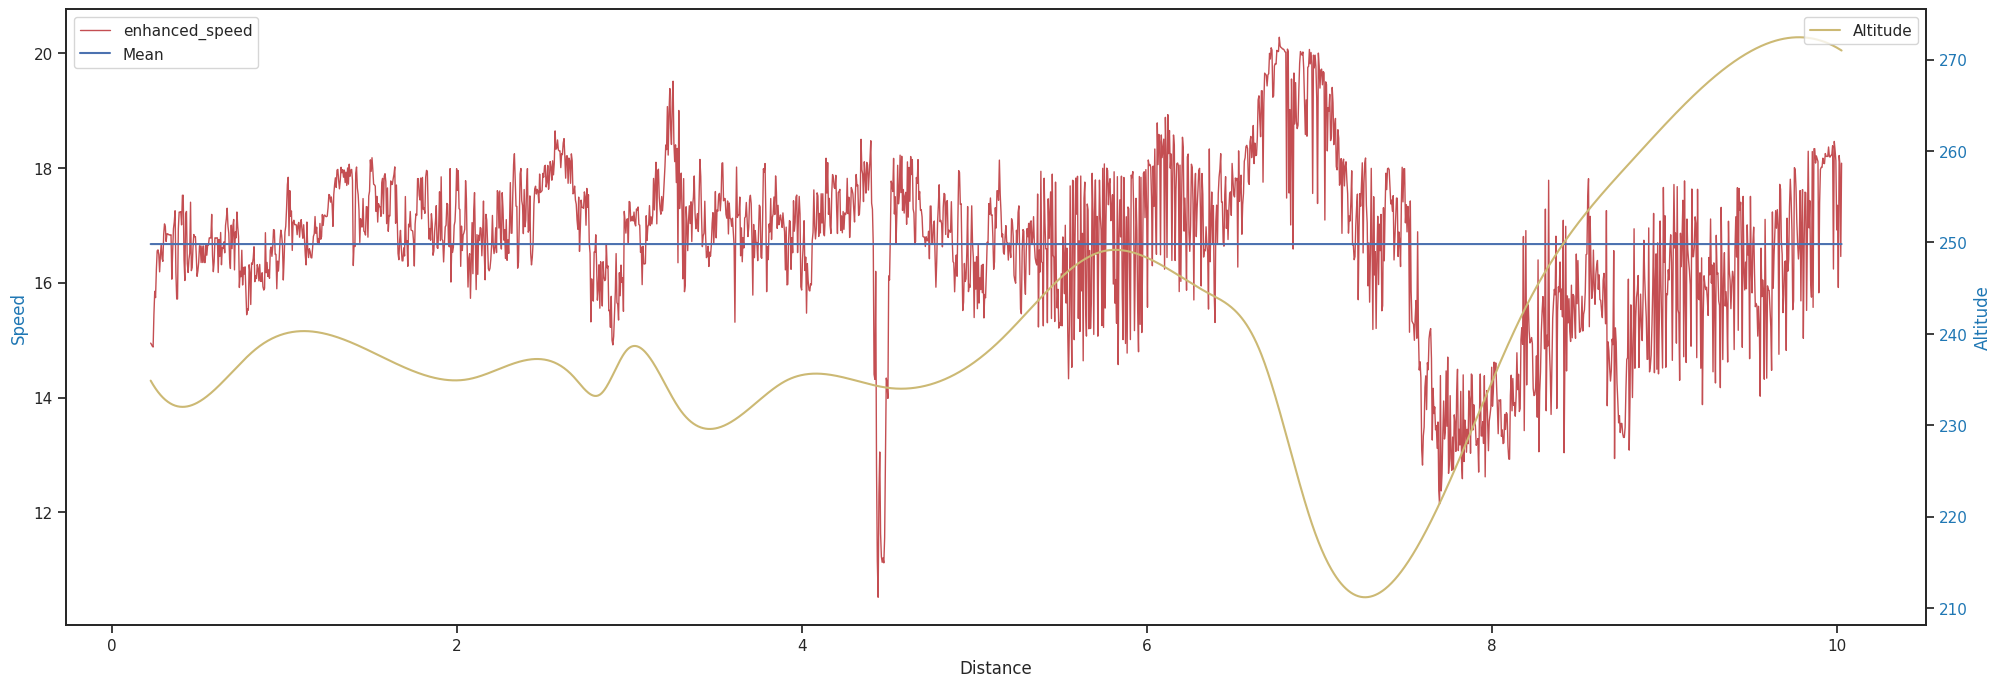

In [96]:
speed_plot = evl.plot(df=test_df[percent_delay:],pred=test_df["enhanced_speed"][percent_delay:],endog = "enhanced_speed",ylabel="Speed", color="blue")

In [97]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate),np.mean(test_df["enhanced_speed"])

(90.44583, 159.16379, 16.639383)

In [98]:
y_pred_ridge = [x if x > 15 else np.mean(test_df["enhanced_speed"]) or x if x < 30 else np.mean(test_df["enhanced_speed"]) for x in test_df["enhanced_speed"]]

In [99]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(test_df["enhanced_speed"])) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds=0
    minutes+=1
final_time = f'Final time: {minutes}:{seconds}'
f'Final time: {minutes}:{seconds}'

'Final time: 36:10'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

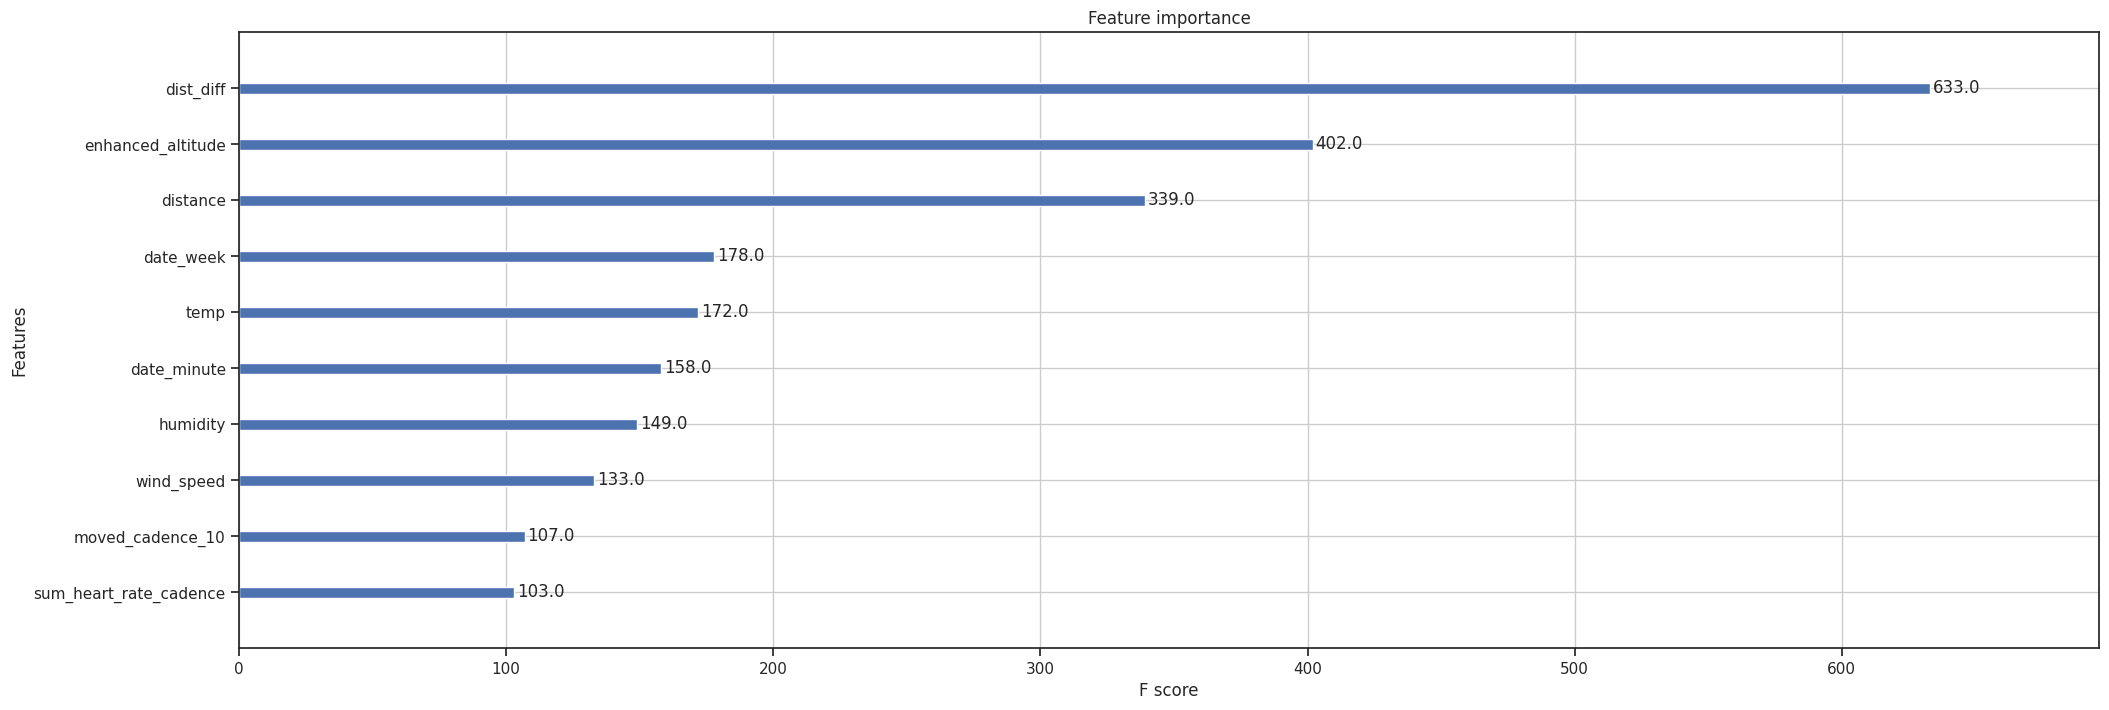

In [100]:
import xgboost as xgb
xgb.plot_importance(clf, max_num_features=10)

In [101]:
hradec = preprocess.load_test_activity(path="tracks/hradec_half.gpx",
                                        race_day ='2023-11-12-11-30')
fit.get_final_df(train_df=train_df,
                 test_df=hradec,
                 model=XGBRegressor(),
                 race_name="hradec",
                 athlete_name="zimola")

'78:28'

In [102]:
silvestrak = preprocess.load_test_activity(path="tracks/silvestrak.gpx",
                                        race_day ='2023-11-12-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=silvestrak,
                 model=XGBRegressor(),
                 race_name="silvestrak",
                 athlete_name="zimola")

'24:13'

In [103]:
boston = preprocess.load_test_activity(path="tracks/boston.gpx",
                                        race_day ='2023-11-12-11-00')
fit.get_final_df(train_df=train_df,
                 test_df=boston,
                 model=XGBRegressor(),
                 race_name="boston",
                 athlete_name="zimola")

'194:55'

In [104]:
import folium
import gpxpy

# Read the GPX file and parse coordinates
gpx_file = "tracks/silvestrak.gpx"
gpx_data = open(gpx_file, "r").read()
gpx_parser = gpxpy.parse(gpx_data)

# Extract coordinates from GPX data
coordinates = []
for track in gpx_parser.tracks:
    for segment in track.segments:
        for point in segment.points:
            coordinates.append([point.latitude, point.longitude])

# Create a folium map centered around the first coordinate
map_center = [coordinates[0][0], coordinates[0][1]]
mymap = folium.Map(location=map_center, zoom_start=14)

# Add polyline to the map
folium.PolyLine(locations=coordinates, color="blue").add_to(mymap)

# Save the map as an HTML file
mymap.save("map.html")

# Read the saved HTML file
with open("map.html", "r") as file:
    html_content = file.read()

# Print or use the HTML content as needed
print(html_content)

<!DOCTYPE html>
<html>
<head>
    
    <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
    
        <script>
            L_NO_TOUCH = false;
            L_DISABLE_3D = false;
        </script>
    
    <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
    <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
    <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
    <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
    <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
    <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
    <link rel="stylesheet" href="

In [105]:
from src.modules import ui_output
ui_output.save_report(athlete_name=conf["Athlete"]["name"],
                      activity_name="bechovice.gpx"
                      .replace(".gpx","")
                      .capitalize(),
                      cad_plot=cad_plot,
                      hr_plot=hr_plot,
                      speed_plot=speed_plot,
                      final_time=final_time,
                      df=test_df)

HTML page with the plots next to each other has been created.


In [106]:
sum(test_df.slope_ascent)

127.8000000000001

In [107]:
ui_output.calc_stride_length(max(test_df.distance), test_df.cadence.mean())

110.88465595641786